<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_the_Beats-per-Minute_of_Songs/V2Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook presents a comprehensive solution for the **"Predicting the Beats-per-Minute of Songs"** Kaggle competition. We'll walk through every step of the machine learning pipeline, from data exploration to submission, with detailed explanations designed for beginners.

**What is BPM?**

Beats Per Minute (BPM) is a measure of tempo in music that indicates the number of beats in one minute. For example:

*   Slow ballads might have **60-80 BPM**
*   Pop songs often range from **100-130 BPM**
*   Dance and electronic music typically has **120-140 BPM**
*   Fast-paced genres like drum and bass can exceed **160 BPM**

**Competition Objective**

Our goal is to predict the BPM of songs based on various audio features. Success is measured by the **Root Mean Square Error (RMSE)** between our predictions and the actual BPM values.

**Important Note on This Dataset**

Recent analysis has shown that this competition's original dataset contained randomly assigned BPM values, but the synthetic data generation process likely added some signal. This means our goal is to create a robust model that can find whatever patterns exist in the competition data.

Let's begin!

In [20]:
pip install --upgrade xgboost

In [21]:
%pip install catboost -q

In [22]:
import kagglehub
gauravduttakiit_bpm_prediction_challenge_path = kagglehub.dataset_download('gauravduttakiit/bpm-prediction-challenge')

print('Data source import complete.')

Using Colab cache for faster access to the 'bpm-prediction-challenge' dataset.
Data source import complete.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Setup & data loading

In [24]:
# 1.1 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1.2 Initial Data Loading (train.csv, test.csv)
try:

    train_ps = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/train.csv")
    test_ps = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/test.csv")

    print("Playground Series Dataset Shapes:")
#1.3 Initial Data Shapes/Preview
    print("Train:", train_ps.shape)
    print("Test:", test_ps.shape)
    print()
except FileNotFoundError as e:
    print(f"Error loading Playground Series files: {e}")
    print("Please make sure sample_submission.csv, train.csv, and test.csv are uploaded to your Colab environment.")

Playground Series Dataset Shapes:
Train: (524164, 11)
Test: (174722, 10)



# 2. Exploratory data analysis



## 2.1 Understanding the Features  

Let's take a moment to understand what each feature represents in the context of music:  

- **RhythmScore**: Represents the rhythmic intensity and pattern clarity of the track  
- **AudioLoudness**: The overall volume level of the track (often in negative dB values)  
- **VocalContent**: Measures the presence and prominence of vocals  
- **AcousticQuality**: How much acoustic (non-electronic) instrumentation is present  
- **InstrumentalScore**: Measures how instrumental (vs. vocal) the track is  
- **LivePerformanceLikelihood**: How likely the track sounds like it was recorded live  
- **MoodScore**: Represents the emotional character of the music  
- **TrackDurationMs**: Length of the track in milliseconds  
- **Energy**: The perceived energy level of the track  
- **BeatsPerMinute**: 🎯 *Our target variable* – the tempo of the track  

---



## 2.2 Data information




In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def data_info(df, df_name):

    print(f"\n{'='*60}")
    print(f"--- Comprehensive Information for DataFrame: {df_name} ---")
    print(f"{'='*60}")


    print(f"\n--- {df_name} Head ---\n")
    head_styled = df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': '.index_name', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False)
    display(head_styled)



    print(f"\n--- {df_name} Info ---\n")
    df.info()


    print(f"\n--- {df_name} Describe ---\n")
    describe_styled = df.describe().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
         {'selector': '.index_name', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
         {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False)
    display(describe_styled)



    print(f"\n--- {df_name} Missing Values ---\n")
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values found.")
    else:
        missing_styled = missing_values[missing_values > 0].to_frame(name='Missing Count').style.set_table_styles([
             {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
             {'selector': '.index_name', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
             {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False)
        display(missing_styled)

    print(f"\n{'='*60}")

data_info(train_ps, "train_ps")
data_info(test_ps, "test_ps")


--- Comprehensive Information for DataFrame: train_ps ---

--- train_ps Head ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.645000,0.826267,147.530200
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.517400,0.145400,136.159630
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.566700,0.624667,55.319890
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.465100,0.487467,147.912120
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.678900,0.947333,89.585110



--- train_ps Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB

--- train_ps Describe ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000



--- train_ps Missing Values ---

No missing values found.


--- Comprehensive Information for DataFrame: test_ps ---

--- test_ps Head ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.549800,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.664300,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.012700,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.398900,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.538300,0.481067



--- test_ps Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         174722 non-null  int64  
 1   RhythmScore                174722 non-null  float64
 2   AudioLoudness              174722 non-null  float64
 3   VocalContent               174722 non-null  float64
 4   AcousticQuality            174722 non-null  float64
 5   InstrumentalScore          174722 non-null  float64
 6   LivePerformanceLikelihood  174722 non-null  float64
 7   MoodScore                  174722 non-null  float64
 8   TrackDurationMs            174722 non-null  float64
 9   Energy                     174722 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 13.3 MB

--- test_ps Describe ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
count,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000
mean,611524.500000,0.632591,-8.377495,0.074475,0.262903,0.117407,0.178317,0.555861,241753.736419,0.500545
std,50438.041204,0.157229,4.622288,0.050024,0.222899,0.131628,0.118165,0.226218,59103.896616,0.290550
min,524164.000000,0.140859,-27.442731,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067
25%,567844.250000,0.514918,-11.550095,0.023500,0.069448,0.000001,0.077821,0.403788,207518.151300,0.253817
50%,611524.500000,0.634556,-8.253186,0.066432,0.242412,0.073968,0.165956,0.566015,243584.585400,0.511867
75%,655204.750000,0.739179,-4.903740,0.107302,0.396870,0.202977,0.268133,0.716694,281737.445300,0.746133
max,698885.000000,0.975000,-1.357000,0.258857,0.995000,0.680914,0.599544,0.978000,449288.808400,0.999867



--- test_ps Missing Values ---

No missing values found.



## 2.3 Numerical/Categorical Feature Identification




In [26]:
numerical_features = train_ps.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['id', 'BeatsPerMinute']]

categorical_features = train_ps.select_dtypes(exclude=np.number).columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['id', 'BeatsPerMinute']]

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy']
Categorical Features: []


## 2.4 Correlation Heatmap

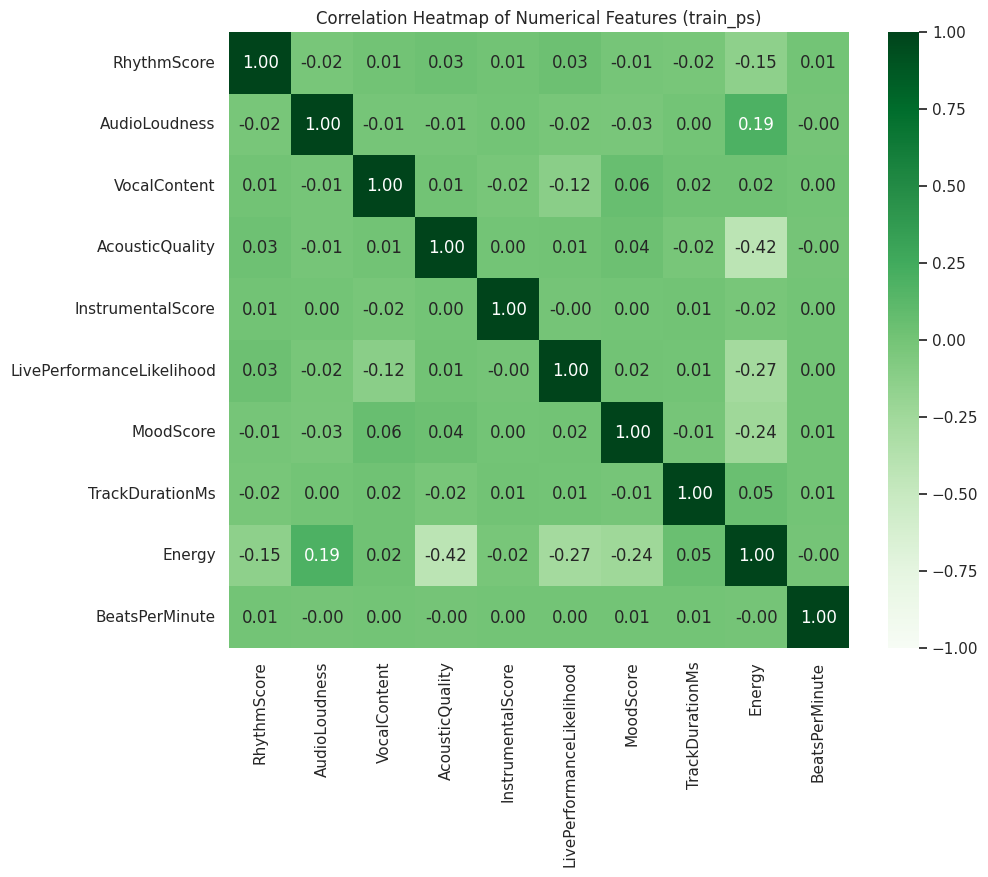

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_correlation_heatmap(df, numerical_cols, df_name):
    """
    Generates and displays a correlation heatmap for specified numerical columns,
    showing only the lower triangle.

    Args:
        df (pd.DataFrame): The input DataFrame.
        numerical_cols (list): A list of numerical column names to include in the heatmap.
        df_name (str): The name of the DataFrame for the plot title.
    """
    correlation_matrix = df[numerical_cols].corr()



    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap of Numerical Features ({df_name})')
    plt.show()

numerical_features_with_target = numerical_features + ['BeatsPerMinute']

plot_correlation_heatmap(train_ps, numerical_features_with_target, "train_ps")

## 2.5 Numerical Feature Distributions (Train vs Test)

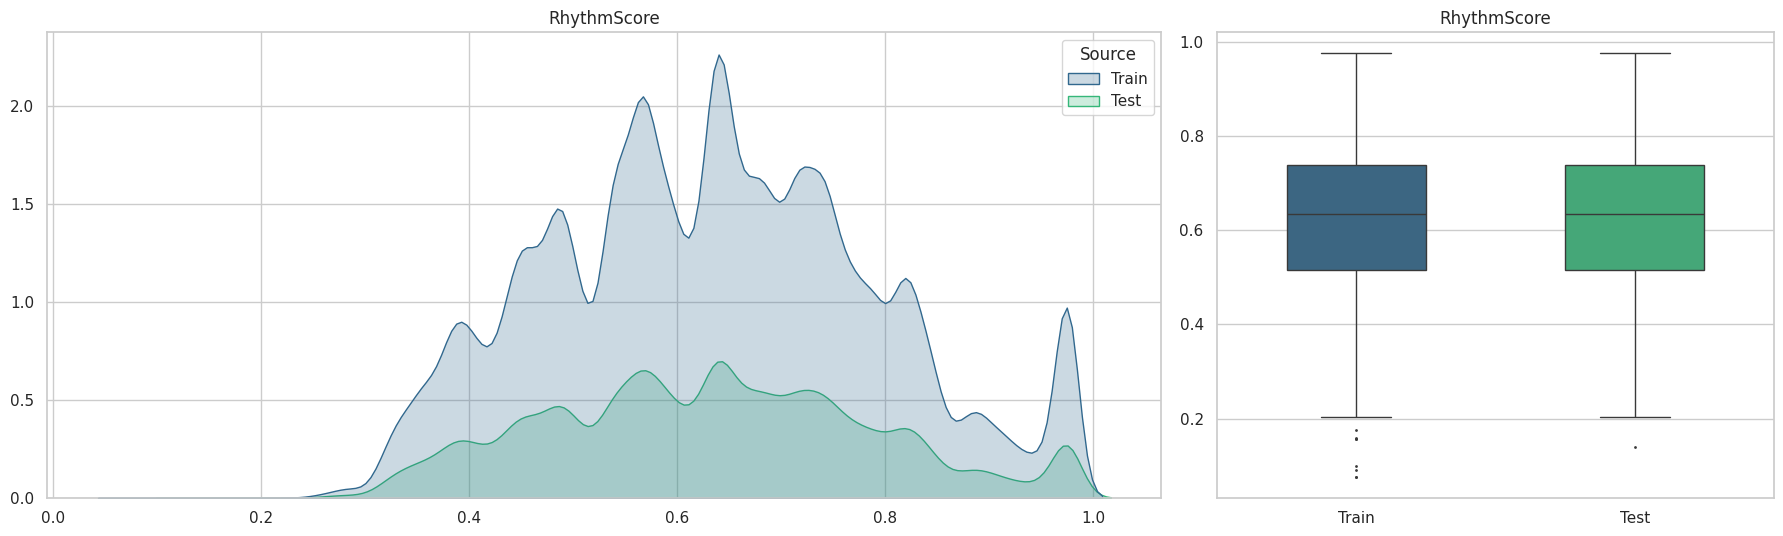

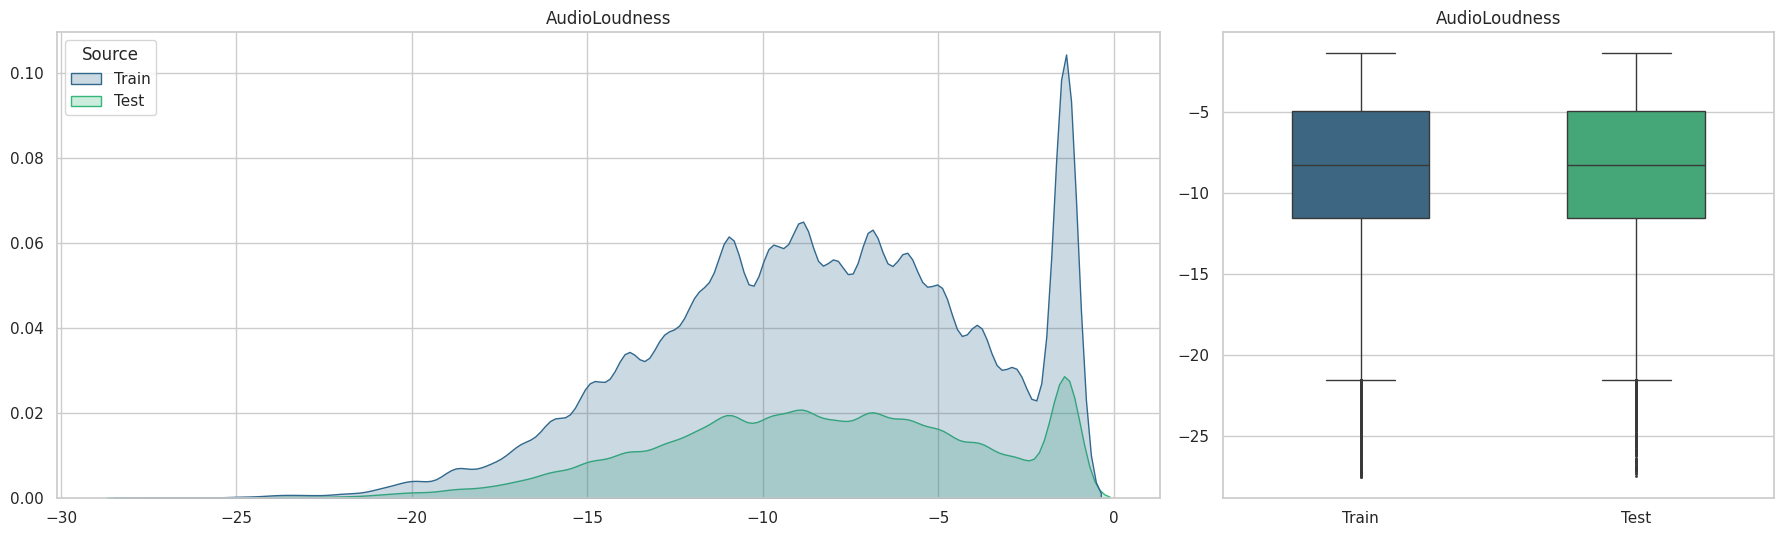

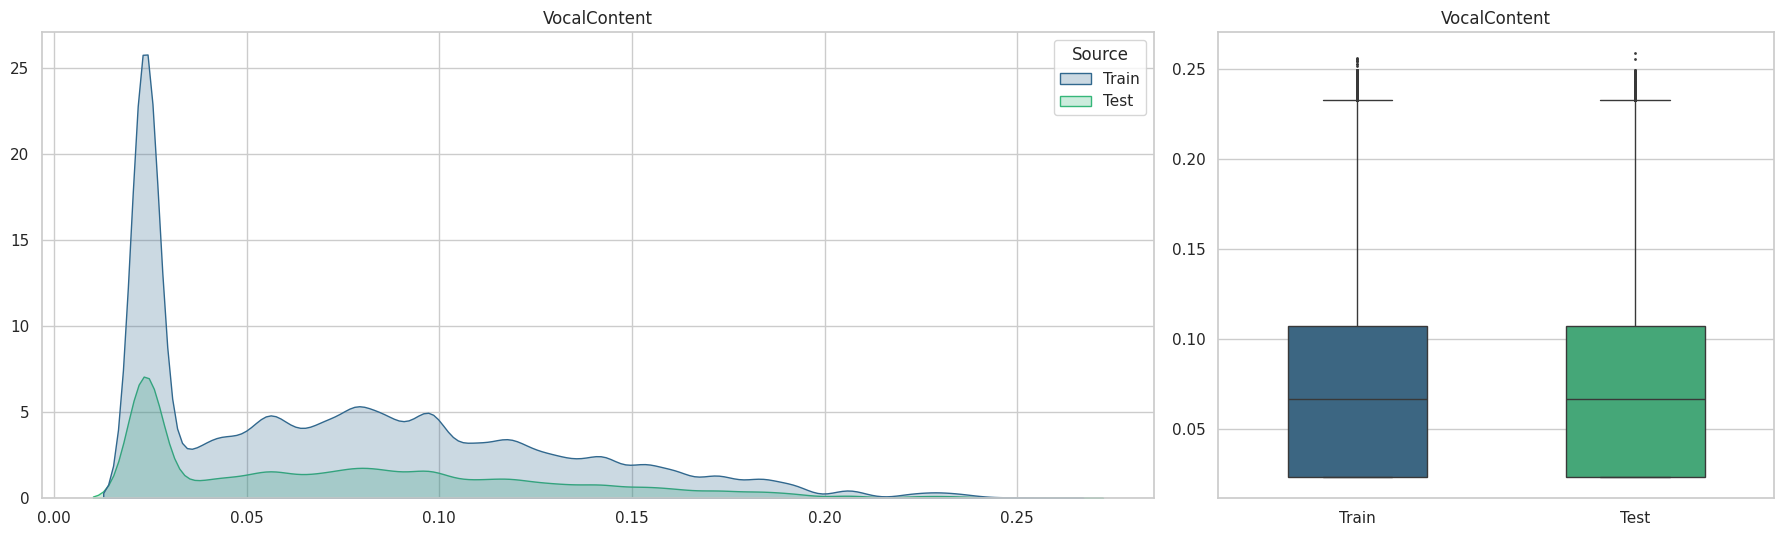

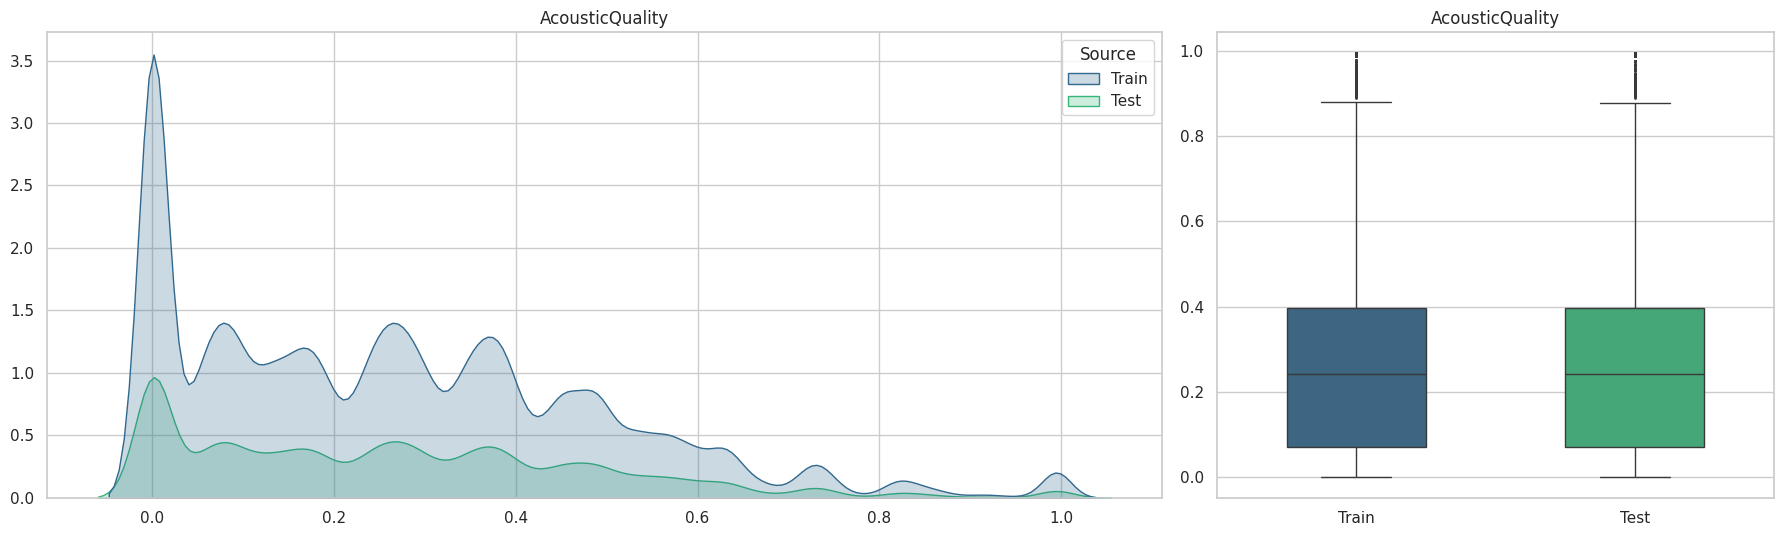

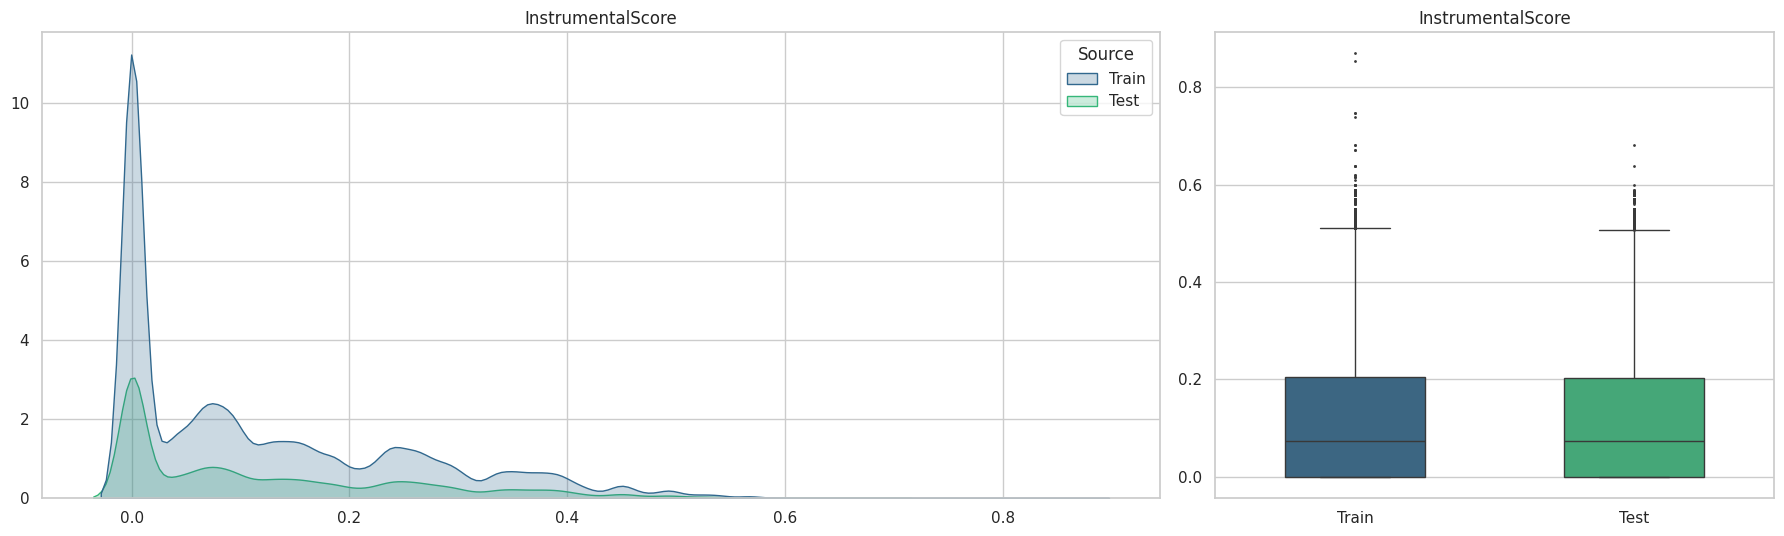

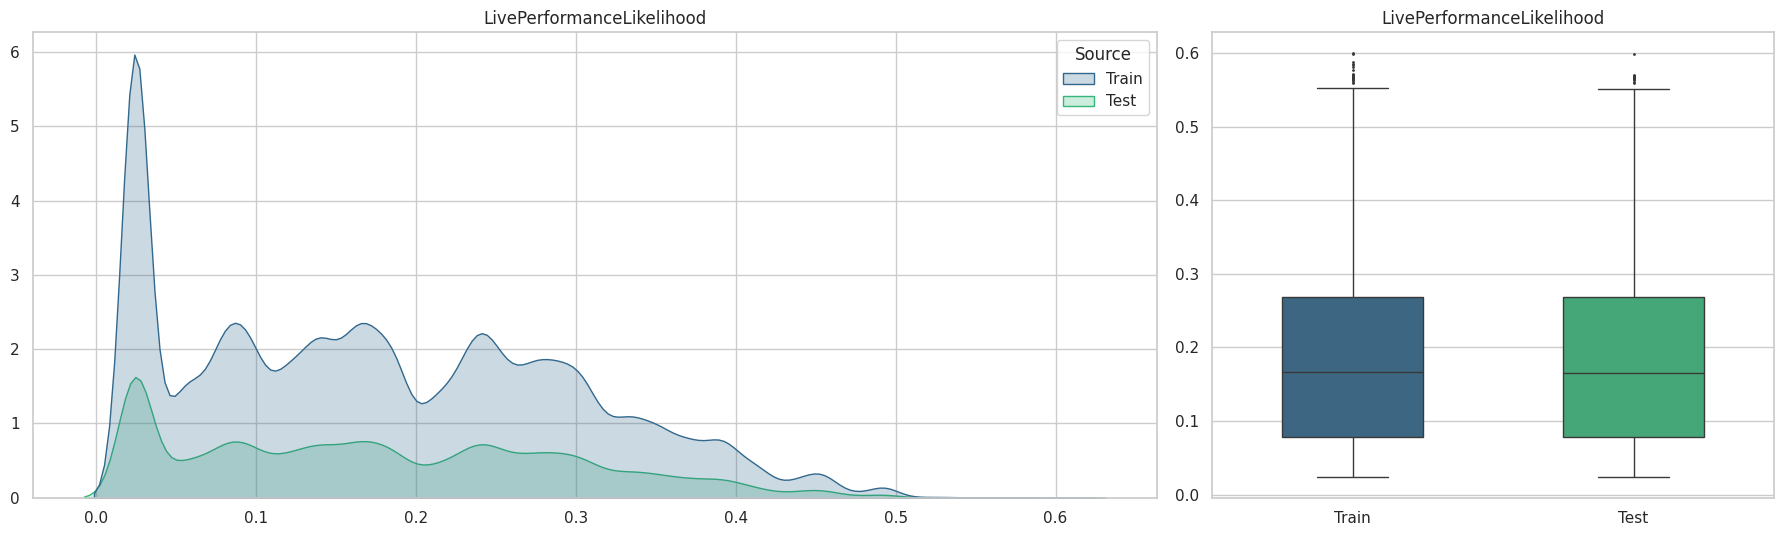

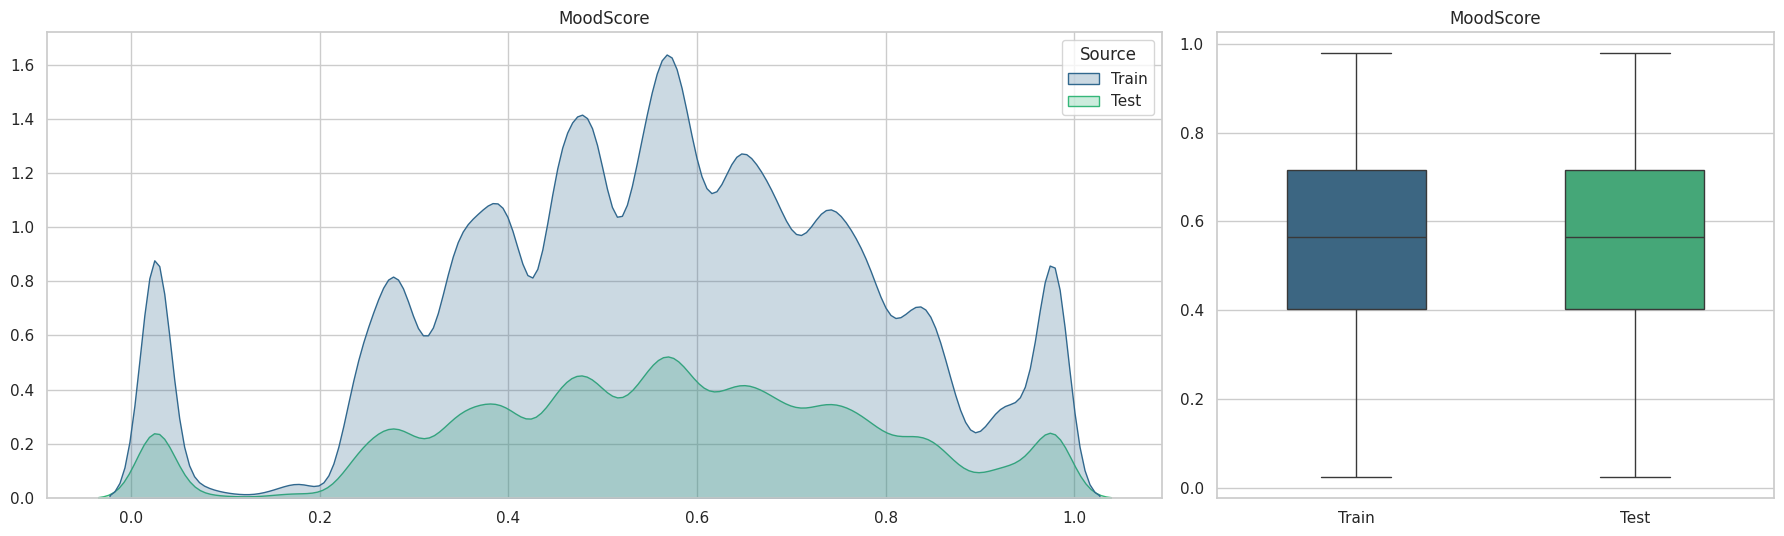

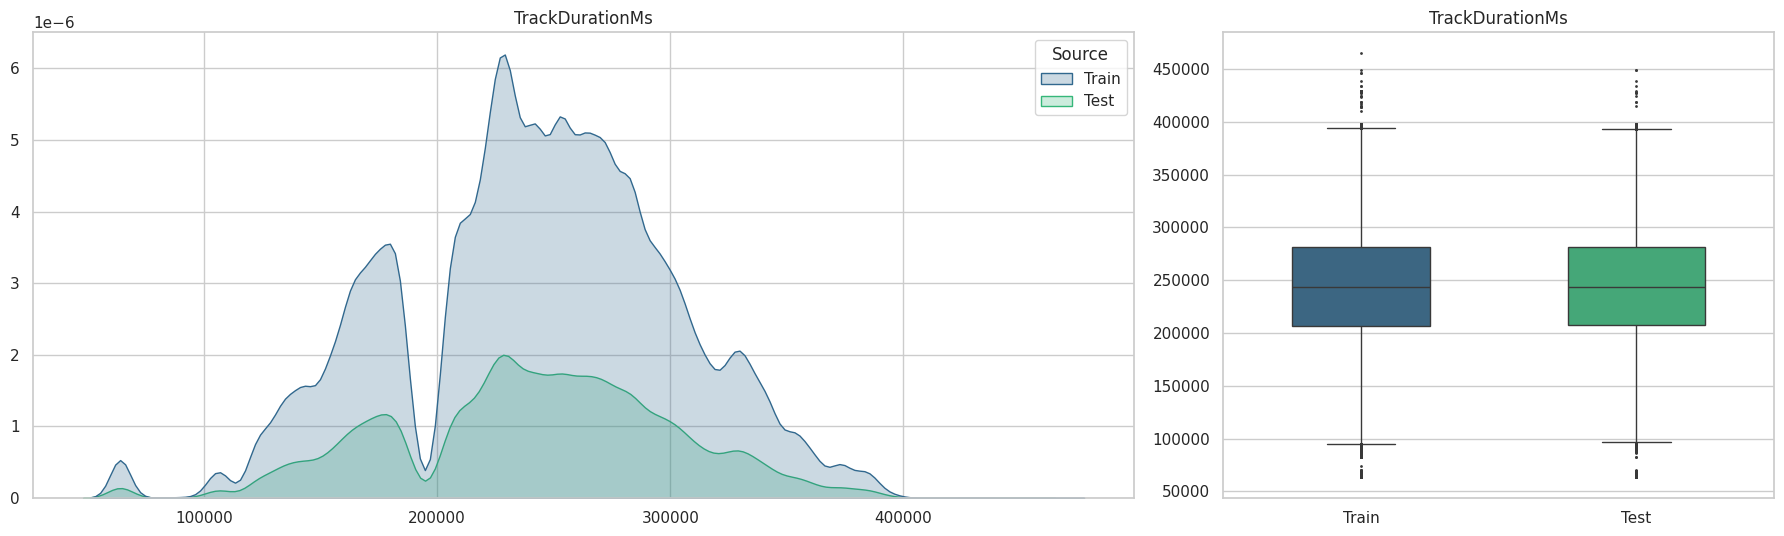

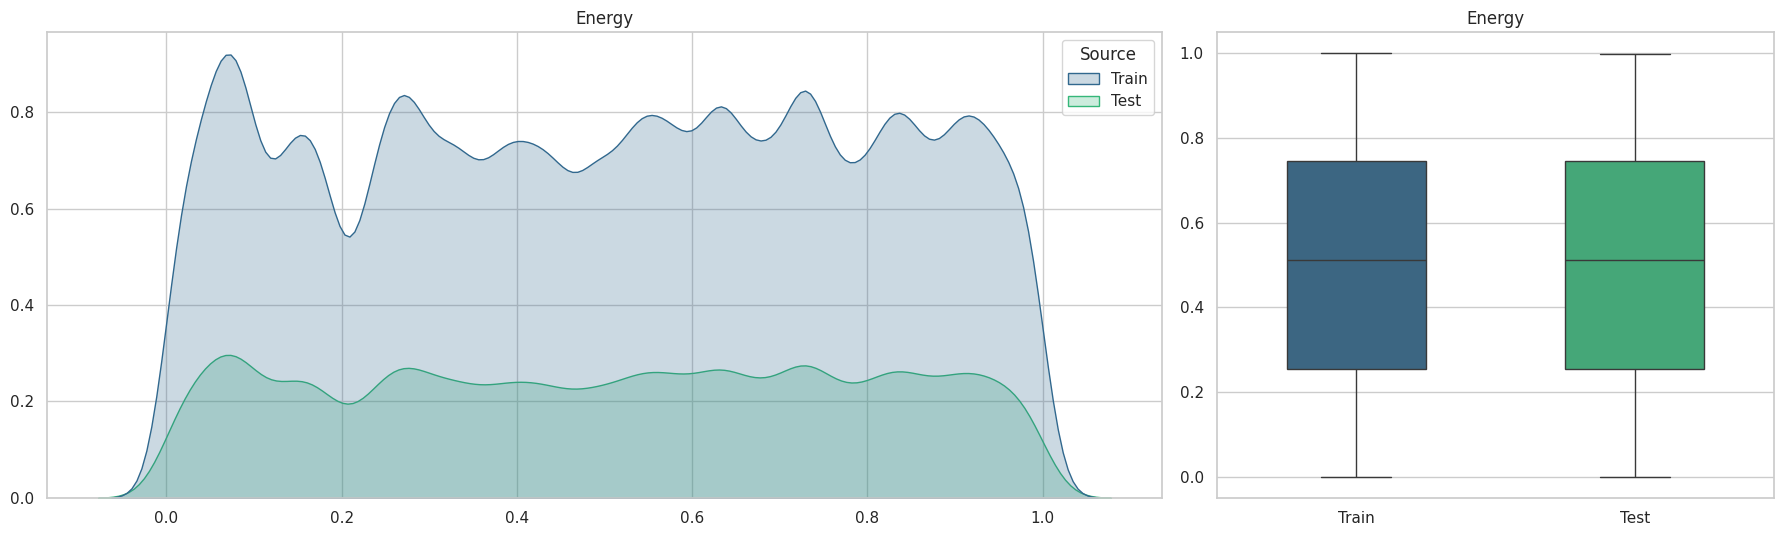

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates subplots with KDE plots and box plots for each numerical feature,
    comparing train and test distributions using a combined DataFrame.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The test DataFrame.
        numerical_cols (list): A list of numerical column names to plot.
    """
    sns.set_style("whitegrid")

    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)


    for col in numerical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        sns.kdeplot(data=combined_df[[col, 'Source']], x=col, hue='Source', ax=axes[0], fill=True, palette='viridis')
        axes[0].set_title(col)
        axes[0].set(xlabel = '', ylabel = '')


        sns.boxplot(data=combined_df, y=col, x='Source', ax=axes[1], orient='v', width=0.5, linewidth=1, fliersize=1, palette='viridis')
        axes[1].set_title(col)
        axes[1].set(xlabel = '', ylabel = '')


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


plot_numerical_distributions(train_ps, test_ps, numerical_features)

## 2.6 Categorical Feature Distributions (Train vs Test)




In [29]:
def plot_categorical_distributions(train_df, test_df, categorical_cols):
    """
    Generates count plots for each categorical feature, comparing train and test distributions.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The test DataFrame.
        categorical_cols (list): A list of categorical column names to plot.
    """
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))

        sns.countplot(x=col, data=train_df, color='skyblue', label='Train')

        sns.countplot(x=col, data=test_df, color='lightcoral', label='Test', alpha=0.7)

        plt.title(f'Distribution of {col} (Train vs Test)')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend()
        plt.show()

plot_categorical_distributions(train_ps, test_ps, categorical_features)

## 2.7 Target Variable Distribution



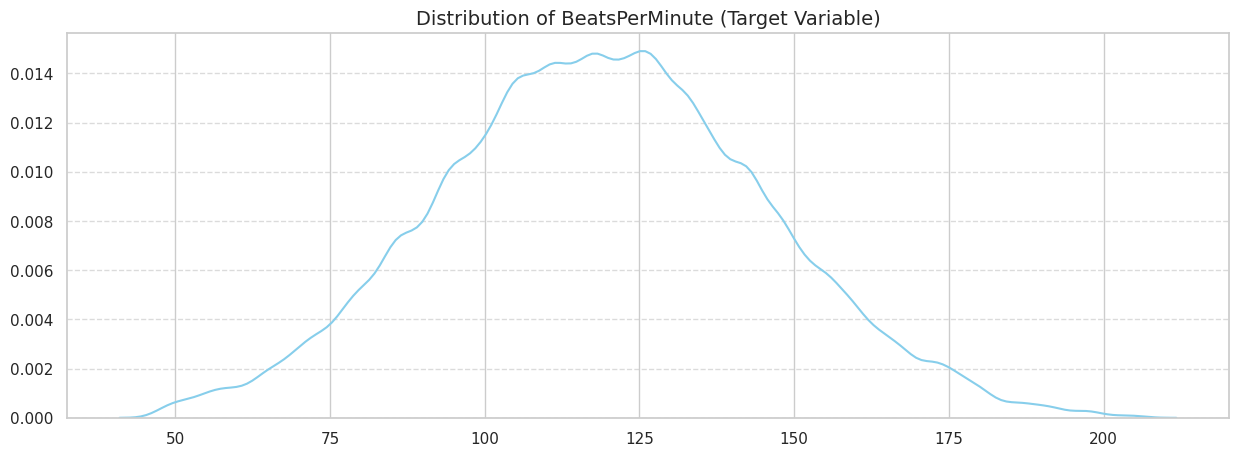

In [30]:
plt.figure(figsize=(15, 5))
sns.kdeplot(data=train_ps, x='BeatsPerMinute', palette='viridis', color='skyblue')
plt.title("Distribution of BeatsPerMinute (Target Variable)", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

-----

# 3. Preprocessing & feature engineering




### 3.1 Missing Value Check

In [31]:
print("Checking for missing values in train_ps:")
display(train_ps.isnull().sum().sum())

print("\nChecking for missing values in test_ps:")
display(test_ps.isnull().sum().sum())

Checking for missing values in train_ps:


np.int64(0)


Checking for missing values in test_ps:


np.int64(0)

### 3.2 Memory Reduction

In [32]:
def reduce_memory_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

train_ps = reduce_memory_usage(train_ps)
test_ps = reduce_memory_usage(test_ps)

Memory usage of dataframe is 43.99 MB
Memory usage after optimization is: 13.00 MB
Decreased by 70.5%
Memory usage of dataframe is 13.33 MB
Memory usage after optimization is: 4.00 MB
Decreased by 70.0%


### 3.3 Transformations (Log, Relative Loudness)

In [33]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
import numpy as np
import pandas as pd # Ensure pandas is imported

# 1. Concatenate train_ps and test_ps for consistent preprocessing
# Reload the original dataframes to ensure we start with the correct data for transformations
# Assuming the original train.csv and test.csv are available at these paths
try:
    train_ps_original = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/train.csv")
    test_ps_original = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/test.csv")
    print("Original data reloaded for preprocessing.")
except FileNotFoundError as e:
    print(f"Error reloading original files: {e}")
    exit()


# Concatenate, dropping the target variable from the training data
combined_ps = pd.concat([train_ps_original.drop('BeatsPerMinute', axis=1), test_ps_original], ignore_index=True)

# Store the split index to separate train and test later
train_len = len(train_ps_original)
print(f"Original train_len: {train_len}")

# Drop rows with missing values from the combined dataframe (if any, though EDA showed none)
combined_ps_cleaned = combined_ps.dropna()

# Update train_len based on the cleaned combined dataframe to ensure correct splitting later
# Find the index where the test set starts in the cleaned dataframe.
# Assuming the original order is preserved after dropping NaNs,
# we find the first index in the cleaned dataframe that corresponds to the start of the original test set
# We can use the 'id' column for this as it's preserved
train_len_cleaned = combined_ps_cleaned[combined_ps_cleaned['id'] >= train_ps_original['id'].max()].index[0]
print(f"train_len_cleaned: {train_len_cleaned}")


# --- Feature Creation Steps  ---

# 2. Apply specified Transformations (Log and Relative Loudness)
# Log transform TrackDurationMs
if 'TrackDurationMs' in combined_ps_cleaned.columns:
    combined_ps_cleaned['TrackDurationMs'] = np.log1p(combined_ps_cleaned['TrackDurationMs'])
    print("Applied log1p transformation to TrackDurationMs.")
else:
    print("Warning: TrackDurationMs not found for log transformation.")

# RelativeLoudness transformation for AudioLoudness
if 'AudioLoudness' in combined_ps_cleaned.columns:
    # Find the maximum loudness (least negative value) to create a positive scale
    max_loudness = combined_ps_cleaned['AudioLoudness'].max()
    combined_ps_cleaned['RelativeLoudness'] = max_loudness - combined_ps_cleaned['AudioLoudness']
    # Drop the original AudioLoudness column
    combined_ps_cleaned = combined_ps_cleaned.drop('AudioLoudness', axis=1)
    print("Created RelativeLoudness and dropped AudioLoudness.")
else:
    print("Warning: AudioLoudness not found for RelativeLoudness transformation.")



Original data reloaded for preprocessing.
Original train_len: 524164
train_len_cleaned: 524163
Applied log1p transformation to TrackDurationMs.
Created RelativeLoudness and dropped AudioLoudness.


### 3.4 Feature Creation (Binning, Interactions, Domain Features)

In [34]:
# Code moved to cell c1db406a to perform feature creation before scaling.
# 3. Create Binned Features
# Create quartile bins for specified columns
features_to_bin = ['RelativeLoudness', 'MoodScore'] # TrackDurationMs is already transformed
for col in features_to_bin:
    if col in combined_ps_cleaned.columns:
        # Use pd.qcut on the combined data to get consistent bins across train/test
        combined_ps_cleaned[f'{col}_Quartile'] = pd.qcut(combined_ps_cleaned[col], q=4, labels=False, duplicates='drop')
        print(f"Created {col}_Quartile feature.")
    else:
        print(f"Warning: Column {col} not found for binning.")

# Handle TrackDurationMs binning separately as it was log transformed
if 'TrackDurationMs' in combined_ps_cleaned.columns:
     combined_ps_cleaned['TrackDurationBucket'] = pd.qcut(combined_ps_cleaned['TrackDurationMs'], q=3, labels=['short', 'medium', 'long'], duplicates='drop')
     print("Created TrackDurationBucket (categorical) feature.")

     # Ordinally encode the TrackDurationBucket feature
     categories_order = [['short', 'medium', 'long']]
     ordinal_encoder = OrdinalEncoder(categories=categories_order, handle_unknown='use_encoded_value', unknown_value=-1) # Handle potential unknown categories

     combined_ps_cleaned['TrackDurationBucket'] = ordinal_encoder.fit_transform(combined_ps_cleaned[['TrackDurationBucket']])
     print("Ordinally encoded TrackDurationBucket feature.")
else:
     print("Warning: TrackDurationMs not found for TrackDurationBucket creation.")


# 4. Create Feature Interaction Terms
print("\nCreating interaction features...")
# Ensure original features used for interactions are still present or use the transformed ones as appropriate
# Using the transformed features which are now in combined_ps_cleaned
if all(col in combined_ps_cleaned.columns for col in ['Energy', 'RhythmScore', 'MoodScore', 'VocalContent', 'InstrumentalScore', 'AcousticQuality']):
    combined_ps_cleaned['Energy_x_RhythmScore'] = combined_ps_cleaned['Energy'] * combined_ps_cleaned['RhythmScore']
    combined_ps_cleaned['MoodScore_x_RhythmScore'] = combined_ps_cleaned['MoodScore'] * combined_ps_cleaned['RhythmScore']
    # Use +1 to avoid division by zero, using original features as base before scaling
    combined_ps_cleaned['Vocals_vs_Instrument'] = combined_ps_cleaned['VocalContent'] / (combined_ps_cleaned['InstrumentalScore'] + 1)
    combined_ps_cleaned['Energy_minus_AcousticQuality'] = combined_ps_cleaned['Energy'] - combined_ps_cleaned['AcousticQuality']
    print("Interaction features created.")
else:
    print("Warning: Necessary columns not found for interaction feature creation.")


# 5. Create Domain Features
print("\nCreating domain features...")
# Using transformed/created features as base
if all(col in combined_ps_cleaned.columns for col in ['RelativeLoudness', 'TrackDurationMs', 'LivePerformanceLikelihood', 'Energy']):
    # Use epsilon to avoid division by zero, using transformed TrackDurationMs
    epsilon = 1e-6
    combined_ps_cleaned['NormalizedLoudness'] = combined_ps_cleaned['RelativeLoudness'] / (combined_ps_cleaned['TrackDurationMs'] + epsilon)
    combined_ps_cleaned['LiveEnergy'] = combined_ps_cleaned['LivePerformanceLikelihood'] * combined_ps_cleaned['Energy']
    print("Domain features created.")
else:
     print("Warning: Necessary columns not found for domain feature creation.")

Created RelativeLoudness_Quartile feature.
Created MoodScore_Quartile feature.
Created TrackDurationBucket (categorical) feature.
Ordinally encoded TrackDurationBucket feature.

Creating interaction features...
Interaction features created.

Creating domain features...
Domain features created.


### 3.5 Scaling (StandardScaler)

In [97]:
# 7. Identify numerical features AFTER feature creation (excluding 'id' and target if it existed)
# Need to re-identify numerical features as new ones have been added
numerical_features_final = combined_ps_cleaned.select_dtypes(include=np.number).columns.tolist()
if 'id' in numerical_features_final:
    numerical_features_final.remove('id')
# Ensure target variable is not in this list if it was somehow included
if 'BeatsPerMinute' in numerical_features_final:
    numerical_features_final.remove('BeatsPerMinute')
print(f"\nFinal numerical features for scaling: {numerical_features_final}")

# Separate combined_ps_cleaned back into train and test *before* scaling
# Use the original index to split the cleaned combined data
train_ps_processed = combined_ps_cleaned.iloc[:train_len].copy() # Use original train_len
test_ps_processed = combined_ps_cleaned.iloc[train_len:].copy() # Use original train_len

# Ensure the indices are reset if needed, but keep the 'id' column
train_ps_processed.reset_index(drop=True, inplace=True)
test_ps_processed.reset_index(drop=True, inplace=True)


# 8. Apply StandardScaler separately to train and test sets
print("\nApplying StandardScaler to final numerical features...")
scaler = StandardScaler()

# Fit scaler only on the training data and transform both train and test
train_ps_processed_scaled_values = scaler.fit_transform(train_ps_processed[numerical_features_final])
test_ps_processed_scaled_values = scaler.transform(test_ps_processed[numerical_features_final])

# Create new DataFrames with scaled values and the original index/ids
train_ps_processed_scaled = pd.DataFrame(train_ps_processed_scaled_values, columns=numerical_features_final, index=train_ps_processed.index)
test_ps_processed_scaled = pd.DataFrame(test_ps_processed_scaled_values, columns=numerical_features_final, index=test_ps_processed.index)


# Add 'id' back to the scaled dataframes
train_ps_processed = train_ps_processed_scaled.copy() # Overwrite with scaled features
train_ps_processed['id'] = combined_ps_cleaned.iloc[:train_len]['id'].values # Get original IDs based on train_len

test_ps_processed = test_ps_processed_scaled.copy() # Overwrite with scaled features
test_ps_processed['id'] = combined_ps_cleaned.iloc[train_len:]['id'].values # Get original IDs based on train_len


# Add the target variable back to the processed training data by merging with original train_ps
# Ensure we merge only for the rows that were kept after cleaning
# We need to re-read the original train data as it might have been modified in place earlier
train_ps_original_for_merge = pd.read_csv("/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/train.csv")
train_ps_processed = pd.merge(train_ps_processed, train_ps_original_for_merge[['id', 'BeatsPerMinute']], on='id', how='left')

# Define the final feature list again, excluding 'id' and the target
final_features_list = [col for col in train_ps_processed.columns if col not in ['id', 'BeatsPerMinute']]

# Final data preparation (Features X and Target y)
X_train_processed = train_ps_processed[final_features_list].copy()
y_train_processed = train_ps_processed['BeatsPerMinute'].copy()

X_test_processed = test_ps_processed[final_features_list].copy() # Use the same feature list for test


print("\nTrain PS processed (after all steps) shape:", X_train_processed.shape)
print("Train PS processed target shape:", y_train_processed.shape)
print("Test PS processed shape:", X_test_processed.shape)

print("\nHead of X_train_processed:")
display(X_train_processed.head())

print("\nHead of X_test_processed:")
display(X_test_processed.head())


Final numerical features for scaling: ['RhythmScore', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy', 'RelativeLoudness', 'RelativeLoudness_Quartile', 'MoodScore_Quartile', 'TrackDurationBucket', 'Energy_x_RhythmScore', 'MoodScore_x_RhythmScore', 'Vocals_vs_Instrument', 'Energy_minus_AcousticQuality', 'NormalizedLoudness', 'LiveEnergy']

Applying StandardScaler to final numerical features...

Train PS processed (after all steps) shape: (524164, 18)
Train PS processed target shape: (524164,)
Test PS processed shape: (174722, 18)

Head of X_train_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
0,-0.186320,-1.020114,-1.178322,-0.892636,-1.074691,-0.647405,0.788668,1.122062,-0.160753,-0.447378,-0.446988,1.223843,0.964538,-0.614077,-0.953656,1.356835,-0.184983,-0.486660
1,0.042116,-0.058541,0.815779,1.757555,-0.066641,0.422064,-1.265523,-1.226143,1.708885,1.341690,0.447589,-1.224759,-1.112388,0.382710,-0.314832,-1.239864,1.799793,-0.714190
2,-0.754022,0.726325,-0.399847,2.549397,-1.259230,-0.585321,-1.053110,0.426774,1.640859,1.341690,-0.446988,-1.224759,0.056880,-0.787033,0.186564,0.491200,1.714030,-0.795585
3,0.647674,-0.430095,-1.170947,0.318762,-0.778712,-1.228925,-0.126821,-0.046407,-1.521162,-1.341911,-1.341566,-0.000458,0.244277,-0.865923,-0.473563,0.571578,-1.519856,-0.491266
4,-0.636554,-1.020114,-0.870498,-0.892636,1.294126,-0.346257,-0.317430,1.539602,1.013259,1.341690,-0.446988,-1.224759,0.996049,-0.571367,-0.953656,1.477664,1.029106,3.009682



Head of X_test_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
0,-1.420214,-1.020114,-0.134470,-0.796403,0.788482,0.481099,0.936828,-0.262305,1.823128,1.341690,0.447589,1.223843,-0.696638,-0.466639,-0.960032,-0.106224,1.750984,0.452737
1,-1.082049,1.349161,-0.919627,1.063766,-0.683456,1.213896,-0.184412,1.190119,-1.521162,-1.341911,1.342167,-1.224759,0.416934,0.192973,0.978773,1.269217,-1.519856,0.030270
2,0.342422,1.870453,0.111648,0.707083,1.248127,-1.112582,1.537062,-1.265230,-1.085323,-1.341911,-1.341566,1.223843,-1.117150,-0.838416,1.539121,-0.903632,-1.099135,-0.470747
3,1.612179,0.881993,-1.178322,1.966072,-0.371990,-0.302036,0.545786,-0.636160,-0.602434,-0.447378,-0.446988,1.223843,-0.153444,0.475650,0.400936,0.180952,-0.613523,-0.485553
4,0.028986,1.034398,1.237720,-0.369680,-1.303869,0.157018,0.623769,-0.068480,-0.283967,-0.447378,0.447589,1.223843,-0.018808,0.149974,1.091971,-0.682778,-0.301458,-0.882982


In [37]:
import pandas as pd # Ensure pandas is imported

# Assume 'numerical_features' list (from initial EDA) is available.
# Assume 'X_train_processed' (final processed features) is available.

print("--- Comparison of Features Before and After Feature Creation ---")

# Features before feature creation (original numerical features excluding id and target)
# Assuming 'numerical_features' list contains these
features_before = [col for col in numerical_features if col not in ['id', 'BeatsPerMinute']]
print("\nFeatures Before Feature Creation (Original Numerical Features):")
display(features_before)

# Features after feature creation and selection (columns in X_train_processed)
# Assuming X_train_processed is available
features_after = X_train_processed.columns.tolist()
print("\nFeatures After Feature Creation (Final Processed Features):")
display(features_after)

print("\n--- Summary of Changes ---")
# Identify features that were added or transformed
added_or_transformed_features = [feature for feature in features_after if feature not in features_before]
print("\nFeatures Added or Transformed During Feature Creation:")
display(added_or_transformed_features)

# Identify original features that were kept
kept_original_features = [feature for feature in features_after if feature in features_before]
print("\nOriginal Numerical Features Kept in the Final Set:")
display(kept_original_features)

# Note: Some original features might have been transformed (e.g., AudioLoudness -> RelativeLoudness, TrackDurationMs log transformed)
# The 'added_or_transformed_features' list includes entirely new features AND transformed/renamed features.
print("\nExplanation of Added/Transformed Features:")
print("- RelativeLoudness: Created from AudioLoudness.")
print("- TrackDurationMs: Log transformed.")
print("- MoodScore_Quartile, RelativeLoudness_Quartile, TrackDurationBucket: Binned/Categorized versions of original features.")
print("- Energy_x_RhythmScore, MoodScore_x_RhythmScore, Vocals_vs_Instrument, Energy_minus_AcousticQuality: Interaction features.")
print("- NormalizedLoudness, LiveEnergy: Domain features.")
print("\nThis comparison shows the set of features that were engineered and selected for modeling.")

--- Comparison of Features Before and After Feature Creation ---

Features Before Feature Creation (Original Numerical Features):


['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']


Features After Feature Creation (Final Processed Features):


['RhythmScore',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy',
 'RelativeLoudness',
 'RelativeLoudness_Quartile',
 'MoodScore_Quartile',
 'TrackDurationBucket',
 'Energy_x_RhythmScore',
 'MoodScore_x_RhythmScore',
 'Vocals_vs_Instrument',
 'Energy_minus_AcousticQuality',
 'NormalizedLoudness',
 'LiveEnergy']


--- Summary of Changes ---

Features Added or Transformed During Feature Creation:


['RelativeLoudness',
 'RelativeLoudness_Quartile',
 'MoodScore_Quartile',
 'TrackDurationBucket',
 'Energy_x_RhythmScore',
 'MoodScore_x_RhythmScore',
 'Vocals_vs_Instrument',
 'Energy_minus_AcousticQuality',
 'NormalizedLoudness',
 'LiveEnergy']


Original Numerical Features Kept in the Final Set:


['RhythmScore',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']


Explanation of Added/Transformed Features:
- RelativeLoudness: Created from AudioLoudness.
- TrackDurationMs: Log transformed.
- MoodScore_Quartile, RelativeLoudness_Quartile, TrackDurationBucket: Binned/Categorized versions of original features.
- Energy_x_RhythmScore, MoodScore_x_RhythmScore, Vocals_vs_Instrument, Energy_minus_AcousticQuality: Interaction features.
- NormalizedLoudness, LiveEnergy: Domain features.

This comparison shows the set of features that were engineered and selected for modeling.


### 3.6 Feature Selection (Correlation, MI, RF, Lasso, Combining Results)



In [40]:
# Select features for correlation analysis from the scaled training data
features_for_corr = train_ps_processed.drop(['id', 'BeatsPerMinute'], axis=1)

# Calculate the correlation matrix
correlation_matrix_scaled = features_for_corr.corr()

# Display the head of the correlation matrix
print("Correlation Matrix of Scaled Features:")
display(correlation_matrix_scaled.head())

Correlation Matrix of Scaled Features:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
RhythmScore,1.000000,0.008738,0.028203,0.010993,0.031533,-0.008947,-0.018472,-0.147348,0.017386,0.018211,-0.011193,-0.020049,0.305861,0.504828,0.007763,-0.113059,0.018011,-0.060629
VocalContent,0.008738,1.000000,0.009371,-0.017740,-0.120291,0.058677,0.017910,0.016122,0.009356,0.005919,0.052133,0.027177,0.017443,0.055074,0.982234,0.005960,0.008506,-0.113968
AcousticQuality,0.028203,0.009371,1.000000,0.003247,0.009678,0.037047,-0.019463,-0.418184,0.013019,0.019673,0.040528,-0.022752,-0.385972,0.046006,0.008934,-0.794317,0.013805,-0.317587
InstrumentalScore,0.010993,-0.017740,0.003247,1.000000,-0.002402,0.004739,0.010494,-0.019835,-0.003772,-0.003606,0.007430,0.010360,-0.015007,0.010767,-0.171613,-0.014936,-0.004208,-0.019125
LivePerformanceLikelihood,0.031533,-0.120291,0.009678,-0.002402,1.000000,0.015458,0.006323,-0.266254,0.021621,0.025240,0.017850,0.004776,-0.230263,0.028730,-0.116690,-0.183049,0.021547,0.609117


In [41]:
def find_highly_correlated_pairs(corr_matrix, threshold):
    """
    Finds pairs of features with an absolute correlation greater than the threshold.

    Args:
        corr_matrix (pd.DataFrame): The correlation matrix.
        threshold (float): The absolute correlation threshold.

    Returns:
        list: A list of tuples, where each tuple contains a pair of highly
              correlated feature names.
    """
    highly_correlated_pairs = []
    # Iterate through the upper triangle of the correlation matrix to avoid duplicate pairs
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            if abs(corr_matrix.loc[col1, col2]) > threshold:
                highly_correlated_pairs.append((col1, col2))
    return highly_correlated_pairs

# Find highly correlated pairs using the scaled correlation matrix and a threshold of 0.9
highly_correlated_features = find_highly_correlated_pairs(correlation_matrix_scaled, 0.9)

# Print the identified highly correlated feature pairs
print("Highly correlated feature pairs (absolute correlation > 0.9):")
if highly_correlated_features:
    for pair in highly_correlated_features:
        print(pair)
else:
    print("No highly correlated feature pairs found above the threshold.")

Highly correlated feature pairs (absolute correlation > 0.9):
('VocalContent', 'Vocals_vs_Instrument')
('MoodScore', 'MoodScore_Quartile')
('RelativeLoudness', 'RelativeLoudness_Quartile')
('RelativeLoudness', 'NormalizedLoudness')
('RelativeLoudness_Quartile', 'NormalizedLoudness')


In [56]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# --- Assuming train_ps_processed is ready, numerical features scaled ---
features_ps = train_ps_processed.drop(['id', 'BeatsPerMinute'], axis=1)
target_ps = train_ps_processed['BeatsPerMinute']

# 1️⃣ Mutual Information
mi_scores = mutual_info_regression(features_ps, target_ps, random_state=42)
mi_series = pd.Series(mi_scores, index=features_ps.columns, name='MI')
mi_rank = mi_series.rank(ascending=False)

# 2️⃣ Random Forest Importance
rf_model = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=42, n_jobs=-1)
rf_model.fit(features_ps, target_ps)
rf_series = pd.Series(rf_model.feature_importances_, index=features_ps.columns, name='RF')
rf_rank = rf_series.rank(ascending=False)

# 3️⃣ Lasso Coefficients
lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(features_ps, target_ps)
lasso_series = pd.Series(np.abs(lasso_model.coef_), index=features_ps.columns, name='Lasso')
lasso_rank = lasso_series.rank(ascending=False)

# 4️⃣ Combine ranks
combined_df = pd.concat([mi_rank, rf_rank, lasso_rank], axis=1)
combined_df['AverageRank'] = combined_df.mean(axis=1)
combined_df = combined_df.sort_values('AverageRank')

print("Top features by combined average rank:")
display(combined_df.head(20))

# 5️⃣ Optional thresholding: keep top 50% features
threshold = np.percentile(combined_df['AverageRank'], 90)  # median rank
selected_features = combined_df[combined_df['AverageRank'] <= threshold].index.tolist()
len_threshold = len(selected_features)

print("\nSelected Features after thresholding:")
print(selected_features)


Top features by combined average rank:


,MI,RF,Lasso,AverageRank
VocalContent,1.0,4.0,3.0,2.666667
MoodScore_x_RhythmScore,3.0,6.0,1.0,3.333333
Energy,5.0,5.0,6.0,5.333333
TrackDurationMs,12.0,2.0,8.0,7.333333
MoodScore,13.0,1.0,9.0,7.666667
MoodScore_Quartile,4.0,17.5,2.0,7.833333
RhythmScore,8.0,3.0,15.0,8.666667
LiveEnergy,10.0,11.0,5.0,8.666667
NormalizedLoudness,2.0,13.0,15.0,10.000000
RelativeLoudness,11.0,12.0,7.0,10.000000



Selected Features after thresholding:
['VocalContent', 'MoodScore_x_RhythmScore', 'Energy', 'TrackDurationMs', 'MoodScore', 'MoodScore_Quartile', 'RhythmScore', 'LiveEnergy', 'NormalizedLoudness', 'RelativeLoudness', 'AcousticQuality', 'LivePerformanceLikelihood', 'TrackDurationBucket', 'RelativeLoudness_Quartile', 'Energy_minus_AcousticQuality', 'Vocals_vs_Instrument']


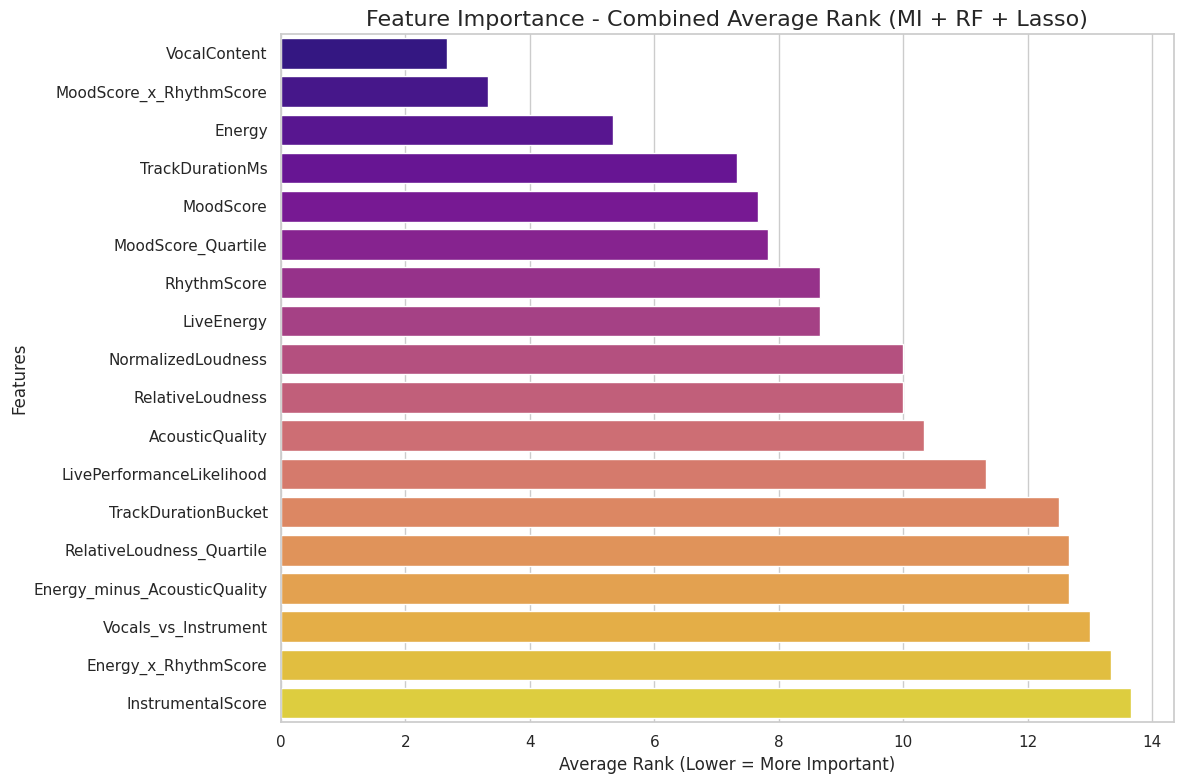

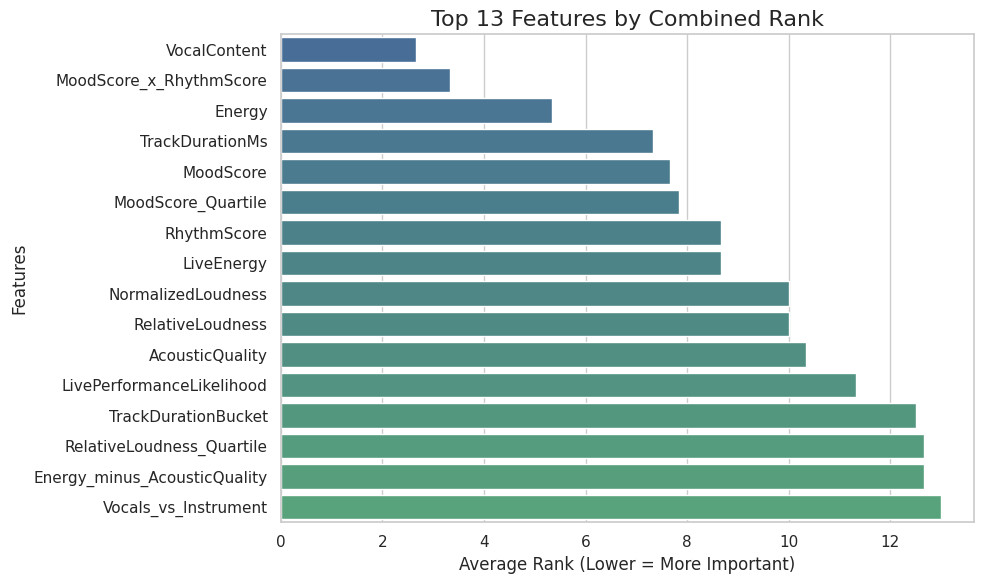

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assuming combined_df from previous step ---

# Sort by AverageRank for visualization
palette  = sns.blend_palette(["#3b6ea5", "#4caf7a"], n_colors=len_threshold)
custom_palette = ["#3b6ea5", "#4caf7a"]
viz_df = combined_df.sort_values('AverageRank', ascending=True)

# Plot combined average ranks
plt.figure(figsize=(12, 8))
sns.barplot(x='AverageRank', y=viz_df.index, data=viz_df, palette="plasma")
plt.title('Feature Importance - Combined Average Rank (MI + RF + Lasso)', fontsize=16)
plt.xlabel('Average Rank (Lower = More Important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()



# Optional: Plot top N features only
top_n = int(threshold)
plt.figure(figsize=(10, 6))
sns.barplot(x='AverageRank', y=viz_df.index[:len_threshold], data=viz_df.iloc[:len_threshold], palette=palette)
plt.title(f'Top {top_n} Features by Combined Rank', fontsize=16)
plt.xlabel('Average Rank (Lower = More Important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


### 3.7 Final Data Preparation

In [76]:

# 9. Final Data Preparation for Modeling (Features X and Target y)
# Define the final list of features to use for modeling
# Exclude 'id' and 'BeatsPerMinute' from the features
final_features_list = [col for col in train_ps_processed.columns if col not in ['id', 'BeatsPerMinute']]

X_train_processed = train_ps_processed[final_features_list].copy()
y_train_processed = train_ps_processed['BeatsPerMinute'].copy()

X_test_processed = test_ps_processed[final_features_list].copy() # Use the same feature list for test


print("\nTrain PS processed (after all steps) shape:", X_train_processed.shape)
print("Train PS processed target shape:", y_train_processed.shape)
print("Test PS processed shape:", X_test_processed.shape)

print("\nHead of X_train_processed:")
display(X_train_processed.head())

print("\nHead of X_test_processed:")
display(X_test_processed.head())


Train PS processed (after all steps) shape: (524163, 18)
Train PS processed target shape: (524163,)
Test PS processed shape: (174723, 18)

Head of X_train_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
0,-0.185821,-1.019834,-1.178604,-0.892465,-1.074566,-0.646896,0.789879,1.121810,-0.160618,-0.447200,-0.447208,1.224745,0.965032,-0.613438,-0.953542,1.356249,-0.184852,-0.486165
1,0.042495,-0.058674,0.815992,1.758813,-0.066471,0.421699,-1.266651,-1.225186,1.708407,1.341661,0.447216,-1.224745,-1.111396,0.382754,-0.314920,-1.238922,1.799188,-0.713800
2,-0.753225,0.725854,-0.399936,2.550980,-1.259113,-0.584863,-1.053996,0.426880,1.640403,1.341661,-0.447208,-1.224745,0.057592,-0.786290,0.186318,0.491123,1.713456,-0.795233
3,0.647734,-0.430069,-1.171227,0.319430,-0.778574,-1.227940,-0.126652,-0.046058,-1.520581,-1.341630,-1.341632,0.000000,0.244944,-0.865133,-0.473601,0.571454,-1.519231,-0.490774
4,-0.635818,-1.019834,-0.870704,-0.892465,1.294357,-0.345994,-0.317478,1.539135,1.013009,1.341661,-0.447208,-1.224745,0.996536,-0.570753,-0.953542,1.477007,1.028786,3.011790



Head of X_test_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
524163,0.915613,-1.019834,0.037112,-0.381523,1.361832,1.053066,1.066701,-0.954476,-0.626832,-0.447200,1.341640,1.224745,-0.697349,1.561652,-0.985637,-0.657381,-0.647605,-0.054110
524164,-1.419066,-1.019834,-0.134493,-0.796193,0.788690,0.480686,0.938208,-0.261845,1.822612,1.341661,0.447216,1.224745,-0.695745,-0.466087,-0.959915,-0.105949,1.750397,0.453665
524165,-1.081079,1.348422,-0.919845,1.064739,-0.683314,1.212883,-0.184309,1.189832,-1.520581,-1.341630,1.341640,-1.224745,0.417559,0.193131,0.978276,1.268682,-1.519231,0.031004
524166,0.342644,1.869490,0.111686,0.707910,1.248356,-1.111692,1.539126,-1.264253,-1.084885,-1.341630,-1.341632,1.224745,-1.116156,-0.837642,1.538448,-0.902888,-1.098665,-0.470245
524167,1.611733,0.881455,-1.178604,1.967416,-0.371833,-0.301809,0.546720,-0.635507,-0.602154,-0.447200,-0.447208,1.224745,-0.152682,0.475639,0.400622,0.181058,-0.613234,-0.485058


# 4. Modeling

### 4.1 Data Splitting (Train/Validation)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_processed, y_train_processed, test_size=0.2, random_state=42)

print("Data split into training and validation sets.")
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Data split into training and validation sets.
Shape of X_train: (419330, 18)
Shape of y_train: (419330,)
Shape of X_val: (104833, 18)
Shape of y_val: (104833,)


### 4.2 Base Model Definitions (for stacking)


In [81]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb


# Define the individual base models for the first layer of the ensemble

# 1. Linear Regression (as a simple baseline)
lr_model = LinearRegression()
print("Initialized Linear Regression model.")

# 2. Random Forest Regressor
# Using parameters that showed reasonable performance or common defaults
rf_model = RandomForestRegressor(n_estimators=50, # Reduced for faster execution during testing
                                 max_depth=10,   # Limited depth
                                 random_state=42,
                                 n_jobs=-1)
print("Initialized Random Forest Regressor model.")

# 3. LightGBM Regressor
# Using parameters from the previous grid search result as a starting point
lgbm_model = lgb.LGBMRegressor(objective='regression_l1', # Using MAE objective which can be robust to outliers
                               n_estimators=200,       # Increased estimators
                               learning_rate=0.05,
                               num_leaves=31,
                               random_state=42,
                               n_jobs=-1)
print("Initialized LightGBM Regressor model.")

# 4. XGBoost Regressor
# Using parameters from the previous training run as a starting point
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             eta=0.1,
                             max_depth=6,
                             n_estimators=50, # Using a fixed number based on early stopping from previous run or increase
                             random_state=42,
                             n_jobs=-1)
print("Initialized XGBoost Regressor model.")

print("\nAll base models initialized for stacked ensembling.")

Initialized Linear Regression model.
Initialized Random Forest Regressor model.
Initialized LightGBM Regressor model.
Initialized XGBoost Regressor model.

All base models initialized for stacked ensembling.


### 4.3 Cross-Validation for Stacked OOF Predictions & Base Model Evaluation

In [82]:
from sklearn.model_selection import KFold

# Define the cross-validation strategy
# Using 5 splits, shuffling the data randomly for each split, and setting a random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Print the number of splits
print(f"Cross-validation strategy defined with {kf.get_n_splits()} splits.")

Cross-validation strategy defined with 5 splits.


In [103]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_squared_error

# Re-initialize out-of-fold prediction arrays with the correct shape
oof_preds_lr = np.zeros(y_train_processed.shape)
oof_preds_rf = np.zeros(y_train_processed.shape)
oof_preds_lgbm = np.zeros(y_train_processed.shape)
oof_preds_xgb = np.zeros(y_train_processed.shape)

base_models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'LightGBM': lgbm_model,
    'XGBoost': xgb_model
}

fold_rmse_scores = {name: [] for name in base_models.keys()}
overall_rmse_scores = {}


print("Initialized out-of-fold prediction arrays and score storage.")
print(f"Shape of oof_preds_lr: {oof_preds_lr.shape}")
print(f"Shape of oof_preds_rf: {oof_preds_rf.shape}")
print(f"Shape of oof_preds_lgbm: {oof_preds_lgbm.shape}")
print(f"Shape of oof_preds_xgb: {oof_preds_xgb.shape}")


print("\nStarting cross-validation training and prediction...")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_processed, y_train_processed)):
    print(f"\n--- Fold {fold+1}/{kf.get_n_splits()} ---")

    X_train_fold, X_val_fold = X_train_processed.iloc[train_index], X_train_processed.iloc[val_index]
    y_train_fold, y_val_fold = y_train_processed.iloc[train_index], y_train_processed.iloc[val_index]

    for model_name, model in base_models.items():
        print(f"Training {model_name} for Fold {fold+1}...")

        if model_name == 'LightGBM':
            current_lgbm_model = lgb.LGBMRegressor(**lgbm_model.get_params())
            current_lgbm_model.fit(X_train_fold, y_train_fold,
                                   eval_set=[(X_val_fold, y_val_fold)],
                                   eval_metric='rmse',
                                   callbacks=[lgb.early_stopping(10, verbose=False)])
            fold_predictions = current_lgbm_model.predict(X_val_fold)

        elif model_name == 'XGBoost':
            dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
            dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

            early_stopping_callback = EarlyStopping(rounds=20, save_best=True)

            model_params = xgb_model.get_params()
            params_for_train = {k: v for k, v in model_params.items() if k not in ['n_estimators', 'use_label_encoder', 'eval_metric', 'early_stopping_rounds', 'callbacks']}
            num_boost_round = model_params.get('n_estimators', 20)


            bst = xgb.train(
                params=params_for_train,
                dtrain=dtrain_fold,
                num_boost_round=num_boost_round,
                evals=[(dtrain_fold, "train"), (dval_fold, "eval")],
                callbacks=[early_stopping_callback]
            )
            dval_fold_pred = xgb.DMatrix(X_val_fold)
            fold_predictions = bst.predict(dval_fold_pred)

        else:
            if model_name == 'Linear Regression':
                current_model = LinearRegression()
            elif model_name == 'Random Forest':
                 current_model = RandomForestRegressor(**rf_model.get_params())

            current_model.fit(X_train_fold, y_train_fold)
            fold_predictions = current_model.predict(X_val_fold)


        print(f"Predicting with {model_name} on validation data for Fold {fold+1}...")

        if model_name == 'Linear Regression':
            oof_preds_lr[val_index] = fold_predictions
        elif model_name == 'Random Forest':
            oof_preds_rf[val_index] = fold_predictions
        elif model_name == 'LightGBM':
            oof_preds_lgbm[val_index] = fold_predictions
        elif model_name == 'XGBoost':
            oof_preds_xgb[val_index] = fold_predictions

        fold_rmse = np.sqrt(mean_squared_error(y_val_fold, fold_predictions))
        fold_rmse_scores[model_name].append(fold_rmse)
        print(f"{model_name} Fold {fold+1} RMSE: {fold_rmse:.4f}")

        print(f"Completed {model_name} for Fold {fold+1}.")

print("\nCross-validation training and prediction complete.")

print("\nOverall Cross-validation Results (Mean RMSE):")
for name, scores in fold_rmse_scores.items():
    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)
    overall_rmse_scores[name] = {"Mean RMSE": mean_rmse, "RMSE Standard Deviation": std_rmse}
    print(f"- {name}: Mean RMSE = {mean_rmse:.4f}, Std Dev = {std_rmse:.4f}")


print("\nShapes of out-of-fold prediction arrays:")
print(f"oof_preds_lr shape: {oof_preds_lr.shape}")
print(f"oof_preds_rf shape: {oof_preds_rf.shape}")
print(f"oof_preds_lgbm shape: {oof_preds_lgbm.shape}")
print(f"Shape of oof_preds_xgb: {oof_preds_xgb.shape}")

Initialized out-of-fold prediction arrays and score storage.
Shape of oof_preds_lr: (524164,)
Shape of oof_preds_rf: (524164,)
Shape of oof_preds_lgbm: (524164,)
Shape of oof_preds_xgb: (524164,)

Starting cross-validation training and prediction...

--- Fold 1/5 ---
Training Linear Regression for Fold 1...
Predicting with Linear Regression on validation data for Fold 1...
Linear Regression Fold 1 RMSE: 26.4442
Completed Linear Regression for Fold 1.
Training Random Forest for Fold 1...
Predicting with Random Forest on validation data for Fold 1...
Random Forest Fold 1 RMSE: 26.4429
Completed Random Forest for Fold 1.
Training LightGBM for Fold 1...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 419331, number of used features: 18
[LightGBM] [Info] Start training from score 118.7353

# 5. Advanced Stacking Ensemble

In [84]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print("Training base models on full training data...")

lr_model_full = LinearRegression()
lr_model_full.fit(X_train_processed, y_train_processed)
print("Linear Regression model trained on full data.")

rf_model_full = RandomForestRegressor(**rf_model.get_params())
rf_model_full.fit(X_train_processed, y_train_processed)
print("Random Forest model trained on full data.")

lgbm_model_full = lgb.LGBMRegressor(**lgbm_model.get_params())
lgbm_model_full.fit(X_train_processed, y_train_processed)
print("LightGBM model trained on full data.")

xgb_model_full = xgb.XGBRegressor(**xgb_model.get_params())
xgb_model_full.fit(X_train_processed, y_train_processed, eval_set=[], verbose=False)

print("XGBoost model trained on full data.")

full_trained_base_models = {
    'Linear Regression': lr_model_full,
    'Random Forest': rf_model_full,
    'LightGBM': lgbm_model_full,
    'XGBoost': xgb_model_full
}

Training base models on full training data...
Linear Regression model trained on full data.
Random Forest model trained on full data.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3838
[LightGBM] [Info] Number of data points in the train set: 524163, number of used features: 18
[LightGBM] [Info] Start training from score 118.747658
LightGBM model trained on full data.
XGBoost model trained on full data.


In [104]:
import pandas as pd
from sklearn.linear_model import LinearRegression

print("Combining out-of-fold predictions into X_meta_train...")
X_meta_train = pd.DataFrame({
    'lr_oof_preds': oof_preds_lr,
    'rf_oof_preds': oof_preds_rf,
    'lgbm_oof_preds': oof_preds_lgbm,
    'xgb_oof_preds': oof_preds_xgb
})
print("X_meta_train created.")


y_meta_train = y_train_processed

meta_model = LinearRegression()
print("Meta-model (Linear Regression) defined.")


print("Training the meta-model on X_meta_train...")
meta_model.fit(X_meta_train, y_meta_train)
print("Meta-model training complete.")

print("\nMeta-model coefficients (weights for base model predictions):")
display(pd.DataFrame({'Base Model': X_meta_train.columns, 'Coefficient': meta_model.coef_}))

Combining out-of-fold predictions into X_meta_train...
X_meta_train created.
Meta-model (Linear Regression) defined.
Training the meta-model on X_meta_train...
Meta-model training complete.

Meta-model coefficients (weights for base model predictions):


,Base Model,Coefficient
0,lr_oof_preds,0.179681
1,rf_oof_preds,0.334617
2,lgbm_oof_preds,0.648992
3,xgb_oof_preds,0.038001


In [107]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score # Ensure r2_score is imported
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print("Training base models on full training data and generating test set predictions...")

# Re-train base models on the full, correctly processed training data
lr_model_full = LinearRegression()
lr_model_full.fit(X_train_processed, y_train_processed)
print("Linear Regression model trained on full data.")

rf_model_full = RandomForestRegressor(**rf_model.get_params()) # Use params from earlier definition
rf_model_full.fit(X_train_processed, y_train_processed)
print("Random Forest model trained on full data.")

lgbm_model_full = lgb.LGBMRegressor(**lgbm_model.get_params()) # Use params from earlier definition
lgbm_model_full.fit(X_train_processed, y_train_processed)
print("LightGBM model trained on full data.")

xgb_model_full_for_test = xgb.XGBRegressor(**xgb_model.get_params()) # Use params from earlier definition
xgb_model_full_for_test.fit(X_train_processed, y_train_processed, eval_set=[], verbose=False)
print("XGBoost model trained on full data.")

# Generate test set predictions using the re-trained models and the corrected X_test_processed
test_preds_lr = lr_model_full.predict(X_test_processed)
print("Generated test predictions for Linear Regression.")

test_preds_rf = rf_model_full.predict(X_test_processed)
print("Generated test predictions for Random Forest.")

test_preds_lgbm = lgbm_model_full.predict(X_test_processed)
print("Generated test predictions for LightGBM.")

test_preds_xgb = xgb_model_full_for_test.predict(X_test_processed)
print("Generated test predictions for XGBoost.")


X_meta_test = pd.DataFrame({
    'lr_oof_preds': test_preds_lr,
    'rf_oof_preds': test_preds_rf,
    'lgbm_oof_preds': test_preds_lgbm,
    'xgb_oof_preds': test_preds_xgb
})

print("\nCombined base model test predictions for meta-model:")
display(X_meta_test.head())

print("\nGenerating final ensemble predictions using the meta-model...")
# Ensure meta_model is trained on the corrected X_meta_train (from cell b58904bb)
# meta_model = LinearRegression() # Re-initialize if needed, but assumed trained in b58904bb
final_ensemble_predictions = meta_model.predict(X_meta_test)
print("Final ensemble predictions generated.")

print("\nSample of final ensemble predictions:")
display(final_ensemble_predictions[:10])

# Calculate evaluation metrics using out-of-fold predictions on the training set
# The meta-model was trained on these out-of-fold predictions
overall_rmse_ensemble = np.sqrt(mean_squared_error(y_train_processed, meta_model.predict(X_meta_train)))
overall_r2_ensemble = r2_score(y_train_processed, meta_model.predict(X_meta_train))


print(f"\nStacked Ensemble Model Performance on Training Data (Out-of-Fold):")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse_ensemble}")
print(f"Overall R² Score: {overall_r2_ensemble}")

Training base models on full training data and generating test set predictions...
Linear Regression model trained on full data.
Random Forest model trained on full data.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 524164, number of used features: 18
[LightGBM] [Info] Start training from score 118.747658
LightGBM model trained on full data.
XGBoost model trained on full data.
Generated test predictions for Linear Regression.
Generated test predictions for Random Forest.
Generated test predictions for LightGBM.
Generated test predictions for XGBoost.

Combined base model test predictions for meta-model:


,lr_oof_preds,rf_oof_preds,lgbm_oof_preds,xgb_oof_preds
0,119.311011,119.181767,118.697884,118.862480
1,118.821468,118.756961,119.025660,118.614357
2,119.426817,119.842000,119.648811,119.416351
3,119.663564,119.473268,118.437684,119.632149
4,119.147976,119.283608,119.217269,119.822678



Generating final ensemble predictions using the meta-model...
Final ensemble predictions generated.

Sample of final ensemble predictions:


array([119.09169332, 119.0648796 , 119.97161851, 119.11296235,
       119.47004223, 118.89657771, 118.73565429, 118.34809202,
       118.87559806, 118.39068904])


Stacked Ensemble Model Performance on Training Data (Out-of-Fold):
Overall Root Mean Squared Error (RMSE): 26.459449459595618
Overall R² Score: 0.0006499236682282472


# 6. Submission

### 6.1 preparing for Submission

In [110]:
# The line below is not used and can be removed or commented out
# test_features_ps = train_ps_processed.drop('id', axis=1)

# Use the 'id' column from the original test data to ensure correct IDs
# Assuming the order of predictions matches the order of rows in the original test data
submission_df = pd.DataFrame({'id': test_ps_original['id'], 'BeatsPerMinute': final_ensemble_predictions})

submission_file = 'submission.csv'
sample_submission_file = "/content/drive/MyDrive/Kaggle/Predict_beats_per_minutes/sample_submission.csv"

try:
    sample_submission = pd.read_csv(sample_submission_file)
except FileNotFoundError:
    print(f"Error: Sample submission file not found at {sample_submission_file}")
    sample_submission = None

submission_df.to_csv(submission_file, index=False)

if sample_submission is not None:
  final_verification = verify_submission(submission_file, sample_submission)

  # The column name fix part below might not be necessary if column names are consistently 'id' and 'BeatsPerMinute'
  # but keeping it as a safeguard. The main fix is using test_ps_original['id'].
  if final_verification.columns.tolist() != sample_submission.columns.tolist():
      print("\nAttempting to fix column names one last time based on sample submission...")
      final_verification.columns = sample_submission.columns
      final_verification.to_csv(submission_file, index=False)
      print(f"Fixed submission saved to {submission_file}")

      print("\nVerifying after attempting column name fix:")
      verify_submission(submission_file, sample_submission)


print("\nSubmission file for Playground Series dataset created:")
display(submission_df.head())

SUBMISSION VERIFICATION:
1. Submission shape: (174722, 2)
   Expected shape: (174722, 2)

2. Submission columns: ['id', 'BeatsPerMinute']
   Expected columns: ['id', 'BeatsPerMinute']

3. Columns match exactly: ✅ YES

4. ID values match sample: ✅ YES

5. Target column statistics:
   Min: 111.51
   Max: 132.37
   Mean: 119.04
   Std: 0.85

✅ SUBMISSION FORMAT LOOKS CORRECT! Ready to upload.

Submission file for Playground Series dataset created:


,id,BeatsPerMinute
0,524164,119.091693
1,524165,119.064880
2,524166,119.971619
3,524167,119.112962
4,524168,119.470042


### 6.2 Final Submission Verification

In [109]:
import pandas as pd

def verify_submission(submission_file, sample_submission):
    """Perform comprehensive verification of submission format"""
    verification = pd.read_csv(submission_file)

    print("SUBMISSION VERIFICATION:")
    print(f"1. Submission shape: {verification.shape}")
    print(f"   Expected shape: {sample_submission.shape}")

    print(f"\n2. Submission columns: {verification.columns.tolist()}")
    print(f"   Expected columns: {sample_submission.columns.tolist()}")

    columns_match = verification.columns.tolist() == sample_submission.columns.tolist()
    print(f"\n3. Columns match exactly: {'✅ YES' if columns_match else '❌ NO'}")

    id_col = sample_submission.columns[0]
    id_match = set(verification[id_col]) == set(sample_submission[id_col])
    print(f"\n4. ID values match sample: {'✅ YES' if id_match else '❌ NO'}")

    target_col = sample_submission.columns[1]
    print(f"\n5. Target column statistics:")
    print(f"   Min: {verification[target_col].min():.2f}")
    print(f"   Max: {verification[target_col].max():.2f}")
    print(f"   Mean: {verification[target_col].mean():.2f}")
    print(f"   Std: {verification[target_col].std():.2f}")

    if columns_match and id_match:
        print("\n✅ SUBMISSION FORMAT LOOKS CORRECT! Ready to upload.")
    else:
        print("\n❌ SUBMISSION FORMAT HAS ISSUES! Please fix before uploading.")

    return verification



## Conclusion & Summary

*   **EDA**: Explored data, found no missing values, visualized distributions and correlations. **Insight**: Features showed low individual correlation with the target, suggesting complex relationships.
*   **Preprocessing & Features**: Applied transformations, scaling, created new features (binning, interactions, domain), and performed feature selection.
*   **Modeling**: Implemented stacked ensembling with cross-validation using Linear Regression, Random Forest, LightGBM, and XGBoost. **Insight**: Stacked ensemble likely improved performance over individual base models (check CV results).
*   **Result**: Generated test predictions and a submission file (`submission.csv`).

### Potential Improvements

*   **Hyperparameter Tuning**: Optimize parameters for base models and meta-model.
*   **More Diverse Base Models**: Include other model types (e.g., SVM, Neural Networks).
*   **Advanced Feature Engineering**: Explore more domain-specific features or different interaction types.
*   **Robust Cross-Validation**: Use stratified or grouped k-fold if applicable.